### Exploration of Pyro Probabilistic Programming.
by Mark Conrad

**Credit to Uber's AI team, I pulled content from their tutorial found at http://pyro.ai/examples/intro_part_i.html**

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [64]:
from torch.autograd import Variable

In [65]:
import pyro
import pyro.distributions as dist

The basic unit of Pyro programs is the stochastic function. This is an arbitrary Python callable that combines two ingredients: deterministic code and primitive stochastic functions.
A stochastic function can be any Python object with __call__() method (e.g. functions, a method or PyTorch nn.Module).


Stochastic primitive functions are distributions, where we can compute the probability of the outputs given the input.
Pyro includes a standalone library, pyro.distributions, of GPU-accelerated multivariate probability distributions built on PyTorch. 

We can draw a sample x from the unit normal distribution N(0,1)

In [66]:
mu = Variable(torch.zeros(10000000)).cuda() # mean = 0
sigma = Variable(torch.ones(10000000)).cuda() # unit variance.
x = dist.normal(mu, sigma).cuda() # x is a sample from N(0,1), we can offload computation to GPUs
x

Variable containing:
 3.4780e-01
-1.4397e-01
 3.8104e-01
     ⋮     
 7.1100e-01
-3.0300e-01
-1.4727e+00
[torch.cuda.FloatTensor of size 10000000 (GPU 0)]

It is important to note that dist.normal is a function that takes parameters and dist.normal(...) returns a sample. Parameters are PyTorch Variables. Variables in PyTorch make use of PyTorch's fast tensor math and autograd capabilities (backprop). Now to score the sample x, computing its log probability according to the distribution N(0,1) we do the following. 

In [67]:
log_p = dist.normal.log_pdf(x, mu, sigma)
np.exp(log_p)

array([[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]], dtype=object)

One core language primitive in Pyro is the pyro.sample statement. Using pyro.sample is as simple as calling a primitive stochastic function with one important difference. 


In [68]:
x = pyro.sample("sample", dist.normal, mu, sigma)
x

Variable containing:
 3.7862e-03
-1.3547e+00
-4.2331e-01
     ⋮     
-1.3666e-01
 9.6226e-01
 3.1143e-01
[torch.cuda.FloatTensor of size 10000000 (GPU 0)]

Just like a direct call to dist.normal, this returns a sample from the unit normal distribution. The crucial difference is that this sample is named. Pyro uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. 


In [69]:
def weather():
    """ We have data on daily mean temperatures and cloud cover and want to reason about how temperature interacts with whether
        it was sunny or cloudy. """
    
    # here we define a binary random variable cloudy which is given by a draw from the bernoulli distribution 
    # with a parameters of 0.3. 

    cloudy = pyro.sample('cloudy', dist.bernoulli, Variable(torch.Tensor([0.3])) )
    # Since this distribution returns a 0 or a 1
    # We convert the value cloud to a string so the values of weather are easier to parse through.
    cloudy = 'cloudy' if cloudy.data[0] == 1.0 else 'sunny'
    # now we define the parameters we are going to use to sample. 
    # Here the average temperatures for cloudy are 55 and 75 for sunny. 
    mean_temp = {'cloudy': [55.0], 'sunny': [75.0]}[cloudy]
    sigma_temp = {'cloudy':[10.0], 'sunny':[15.0]}[cloudy]
    temp = pyro.sample('temp', dist.normal, Variable(torch.Tensor(mean_temp)),
                      Variable(torch.Tensor(sigma_temp)))
    return cloudy, temp.data[0]
for _ in range(3):
    print(weather())

('sunny', 46.485740661621094)
('sunny', 67.42657470703125)
('sunny', 59.7248420715332)


weather() is a non-deterministic (same input does not guarantee the same output) Python callable that returns two random samples. 
The randomness is invoked witht the pyro.sample. 
Moreover, the weather() specifies a joint probability distribution over two named random variables: cloudy and temp. 
With this, it defines a probabilistic model that we can reason about using the techniques of probability theory. 
For instance, if I observe a temperature of 70 degrees, how likely is it to be cloudy? 
We will continue to explore this in the next example.



In [70]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = [200] if cloudy == 'sunny' and temp > 80.0 else [50]
    ice_cream = pyro.sample('ice_cream',dist.normal, Variable(torch.Tensor(expected_sales)),
                           Variable(torch.Tensor([10.0])))
    return ice_cream

Uber states that Pyro is embedded into Python, stochastic functions can contain arbitrarily complex determinestic Python and randomness can freely affect control flow. We can construc t recursive functions that terminate their recursion nondeterministically, provided we take care to pass pyro.sample unique sample names whenever it's called. 

In [71]:

def geometric(p, t = None):
    """Output produced is generated dynamically and different executions can have different numbers of named random variables."""
    if t is None:
        t = 0
    x = pyro.sample("x+{}".format(t), dist.bernoulli, p)
    if torch.equal(x.data, torch.zeros(1)):
        return x
    else:
        return x + geometric(p, t+1)
print(geometric(Variable(torch.Tensor([0.5]))))

Variable containing:
 1
[torch.FloatTensor of size 1]



We can also define stochastic functions that accept as input or produce as output other stochastic functions:


In [72]:
def normal_product(mu, sigma):
    z1 = pyro.sample("z1", dist.normal, mu, sigma)
    z2 = pyro.sample("z2", dist.normal, mu, sigma)
    y = z1 * z2
    return y

# here we are defining a stochastic function
def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.normal, Variable(torch.zeros(1)), Variable(torch.ones(1)))
    fn = lambda sigma: normal_product(mu_latent, sigma)
    return fn
make_normal_normal()(Variable(torch.ones(1)))

Variable containing:
 1.2758
[torch.FloatTensor of size 1]

The fact that Pyro supports arbitrary Python code like this -iteration, recursion, higher-order functions, etc - in conjunction with random control flows means that Pyro stochastic functions are universal, i.e. they can be used to represent any computable probability distribution. 

Pyro is built on top of PyTorch to take advantage of dynamic computational graphs which are an important ingredient in allowing for unviersal models that can benefit from GPU-accelerated tensor math. 


In [73]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

## Inference in Pyro: From Stochastic Functions to Marginal Distributions

Stochastic functions induce a joint probability distribution p(y,z | x) over their latent variables z and return values y, and this joint distribution induces a marginal distribution over return values of the function. However, for non-primitive stochastic functions, we can no longer explicitly compute the marginal probability of an output p(y|x) or draw samples from the marginal distribution over return values y ~ p(y|x) 


In the most generalizeable construct, we can view inference in a universal probabilistic programming language like Pyro to be a problem of constructing this marginal distribution given an arbitrary boolean constraint so that we can perform these computations. The constrain can be deterministic, and hinge on the return value, the internal randomness, or both. 
Bayesian inference or posterior inference is an important special case of this more general formulation that admits tractable approximiations. In Bayesian inference, the return value is always the values of some subset internal sample statements, and the constraint is an equality constraint on the other internal sample statements. According to the documentation much of modern machine learning can be cast as approximate Bayesian inference and expressed succintly in a language like Pyro.
Next we will make a generative model.

#### Representing marginal distributions
Suppose we are trying to figure out how much something weights, but the scale is unreliable, we can try to compensate for this by integrating the noisy measurement info with a guess based on prior knowledge about the object, like its density or material properties. 

In [74]:
def scale(guess):
    # the prior over weight encodes our uncertainty about our guess.
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # this encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight.
    return pyro.sample('measurement', dist.normal, weight, Variable(torch.Tensor([.75])))

Let's analyze the models behavior, in particular, we can use importance sampling to simulate the marginal distribution of measurement values we'd expect to see a priori for a given guess.
Marginalization in Pyro is split between two steps, first we collect a number of weighted execution traces of the model, then we can collpase those traces into a histogram over possible return values given a particular set of arguments.
We use pyro.infer.Marginal
Sampling can be done either through sampling, or, for models with only discrete latent variables, exact enumeration. to create a basic importance sampler over execution traces (using the prior as a proposal distribution), we can write:


In [75]:
posterior = pyro.infer.Importance(scale, num_samples=1000)

By itself the posterior is not very useful, though advanced users can call it with arguments for scale to sample a raw execution trace.
Instead, the posterior is meant to be consumed by pyro.infer.Marginal, which creates a primitive stochastic function with the same input and output types as scale.


In [76]:
guess = Variable(torch.Tensor([8.5]))
marginal = pyro.infer.Marginal(posterior)
marginal(guess)

Variable containing:
 7.4698
[torch.FloatTensor of size 1]

When called with an input guess, marginal first uses posterior to generate a seuqnece of weighted execution traces given guess, then builds a histogram over return values from the traces, and finally returns a sample drawn from the histogram. Calling marginal with the same arguments more than once will sample from the same histogram. 


Text(0,0.5,'#')

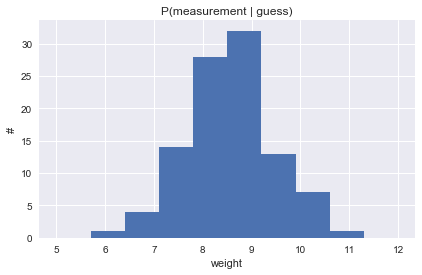

In [77]:

plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")



pyro.infer.Marginal also accepts the optional keyword argument sites = [name1, name2, ...] that provides a list of names of latent variables. When sites is specified, marginal will return a dictionary where the keys are the names in sites and the values are values at those sites from a single execution trace. 
This is useful because we may wish to compute many different marginals from the same posterior object.




The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data. In Pyro, we separate the expression of conditioning from its evaluation via inference, making it possible to write a model once and condition it on many different observations. We can constrain a models internal sample statement to be equal to a given set of observations.


We will consider scale once more, suppose we want to sample from the marginal distribution of weight give ninput guess== 0.5
but now we have observed that measurement ==0.1. Pyro provides the function pyro.condition to allow us to constrain the values of sample statements. pyro.condition is a higher-order function that takes a model and a dictionary of data and returns a new model that has the same input and output signatures but always uses the given values at observed sample statements. 

In [78]:
conditioned_scale = pyro.condition(scale, data= {"measurement": Variable(torch.Tensor([8.5]))})

This is just like a Python function, conditioning can be deferred to or parametrized with lambda or def.


In [79]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data= {'measurement': measurement})(*args, **kwargs)

In some cases it may be convenient to pass observation directly to individual pyro.sample statements instead of using pyro.condition. The option obs keyword argument is reserved by pyro.sample for that purpose; furthermore, pyro.observe is an alias for pyro.sample with obs.


In [80]:
# equivalent to pyro.condition(scale, data= {"measurement": Variable(torch.ones(1
def scale_obs(guess):
    z= pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.ones(1)),
                      obs=Variable(torch.Tensor([0.1])))

# equivalent to scale_obs:
def scale_obs(guess):
    z = pyro.sample('weight', dist.normal, guess, Variable(torch.ones(1)))
    return pyro.observe('measurement', dist.normal, Variable(torch.ones(1)),
                       weight, Variable(torch.Tensor([0.1])))

Hardcoding is not usually recommended due to its invasive non-compositional nature. However, pyro.condition may be composed freely to form multiple complex queries on probabilistic model without modifying the underlying model. The only restriction is that a single site may only be constrained once.


In [81]:
def scale2(guess):
    weight = pyro.sample('weight', dist.normal, guess, Variable(torch.ones(1)))
    tolerance = torch.abs(pyro,sample('tolerance', dist.normal, Variable(torch.zeros(1)),
                                     Variable(torch.ones(1))))
# conditioning composes:
# the following are all equivalent and do not interfere with each other.
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": Variable(torch.ones(1))}),
    data={"measurement": Variable(torch.ones(1))})
conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": Variable(torch.ones(1))}),
    data={"weight": Variable(torch.ones(1))})
conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": Variable(torch.ones(1)), "measurement": Variable(torch.ones(1))})

In addition to pyro.condition for incorporating observations, Pyro also contains pyro.do an implementation of Pearl's do-operator used for causal inference with an identical interface to pyro.condition.condition and do can be mixed and composed freely, making Pyro a powerful tool for model-based causal inference.


In [82]:
guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))
conditioned_scale = pyro.condition(scale, data={'measurement': measurement})
marginal = pyro.infer.Marginal(pyro.infer.Importance(conditioned_scale, num_samples= 1000),
                              sites=["weight"])

marginal(guess)

{'weight': Variable containing:
  10.3637
 [torch.FloatTensor of size 1]}

Text(0,0.5,'#')

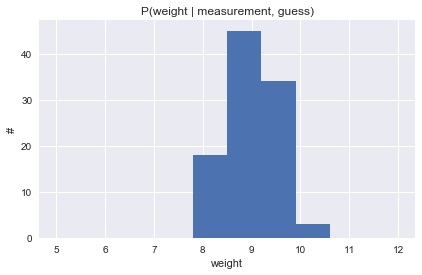

In [83]:
plt.hist([marginal(guess)['weight'].data[0] for i in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel('weight')
plt.ylabel("#")

         

This is computationally inefficient because the prior distribution over weight may be very far from the true distribution over weights, especially if our initial guess is not very good.
Therefore, some inference algorithms in Pyro, like pyro.infer.Importance and pyro.infer.SVI allow us to use arbitrary stochastic functions, which we will call guide functions or guides, as approximate posterior distributions. These guide functions must satisfy two criteria to be valida approximations for a particular model: all unobserved sample statements that appear in the model appear in the guide. 
The guide has the same input signature as the model (same arguments)..


Guides serve as programmable, data dependent proposal distributions for importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metro Hastings, and as variational distributions or inference networks for stochastic variational inference. Currently, Pyro has only importance sampling and stochastic variational inference implemented. Other algorithms will be added soon.


Guide is defined differently across algorithms for inference, the guide function should generally be chosen so that it closely approximates the distribution over all unobserved sample statements in the model. 
The simplest guide for deferred_conditioned_scale matches the prior distribution over weight.


In [84]:
def scale_prior_guide(guess):
    return pyro.sample('weight', dist.normal, guess, Variable(torch.ones(1)))
posterior = pyro.infer.Importance(conditioned_scale,guide= scale_prior_guide, num_samples= 100)
marginal = pyro.infer.Marginal(posterior, sites =["weight"])

Can we do better than the prior?


Text(0,0.5,'#')

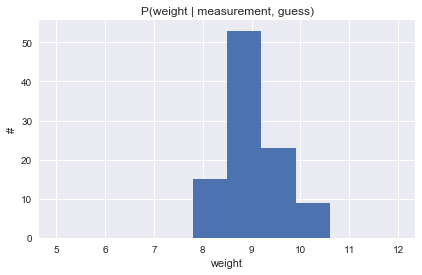

In [85]:
# it turns out that the true posterior distribution over weight given guess and measurement can be 
# written directly as
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements we are conditioning on.
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = Variable(torch.ones(1)) / (measurement.size(0) + 1.0)
    return pyro.sample('weight', dist.normal, a,b)
posterior = pyro.infer.Importance(deferred_conditioned_scale, guide = scale_posterior_guide, num_samples=100)
marginal = pyro.infer.Marginal(posterior, sites = ['weight'])
plt.hist([marginal(measurement, guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

It is generally intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function. What we can do instead is use the top-level function pyro.param to specify a family of guides indexed by named parameters, and search for the member of the family that is the best approximation. This approach is called variational inference.

pyro.param is a frontend for Pyro's key-value parameter store. Like pyro.sample, pyro.param is always called with a name as its first argument. The first time pyro.param is called with a particular name, it stores its arguments in the parameter store and then returns that value. After that, when it is called with that name, it returns the value from the parameter store regardless of any other arguments. It is similar to simple_param_store.setdefault, but with some additional tracking and management functionality. 


In [86]:
simple_param_store = {}
a = simple_param_store.setdefault("a", torch.randn(1))

In [88]:

def scale_parametrized_guide(guess):
    a = pyro.param("a", Variable(torch.randn(1) + guess.data.clone(), requires_grad=True))
    b = pyro.param("b", Variable(torch.randn(1), requires_grad=True))
    return pyro.sample("weight", dist.normal, a, torch.abs(b))

Pyro is built to enable stochastic variational inference, a powerful and widely applicable class of variational ifnerence algorithms with three key characteristics. ! parameters are always real-valued tensors. 
We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide . We use stochastic gradient descent to search for the optimial parameters.

Combining stochastic gradient descent with PyTorch's GPU accelerated tensor math and automatic differentiation allows us to scale variational inference to very high-dimensional parameter spaces and massive datasets.
Stochastic variational inference: 


Text(0,0.5,'loss')

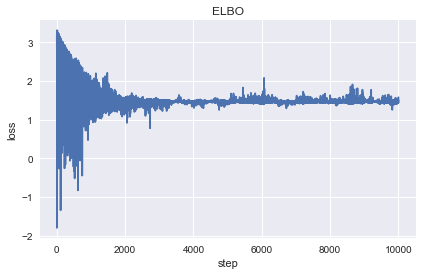

In [90]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.ClippedAdam({"lr": 0.001}),
                     loss="ELBO")

losses = []
for t in range(10000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

The optimization updates the guide parameters, but does not produce a posterior distribution object itself. Once we find good parameters, we can just use the guide as a representation of the model's approximate posterior for downstream tasks.


Text(0,0.5,'#')

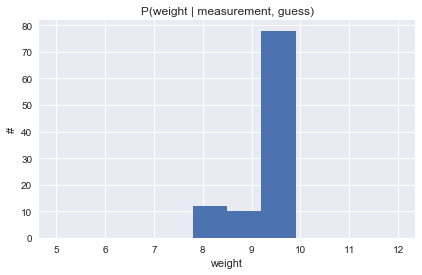

In [92]:

posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.Marginal(posterior, sites=["weight"])

plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

Here we used optimized guide as an importance distribution for estimating the marginal distribution over weight with many fewer samples than the prior.


Text(0,0.5,'#')

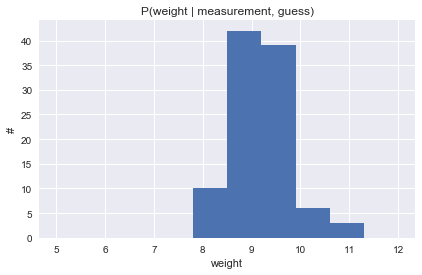

In [93]:

plt.hist([scale_parametrized_guide(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

Pyro has taken great care to support stochastic variational inference as a general purpose inference algorithm. 
We use the model we previously defined, the model is given as a stochastic function (model(*args, **kwargs), which in the general cases takes arguments. The different pieces of model() are encoded via the mapping:

observations <= pyro.observe

latent random variables <= pyro.sample

parameters.<= pyro.param



The model has observations x and latent random variables z as well as parameters theta. It has a joint probability density of the form. 

p_theta(x,z) = p_theta(x|z) p_theta(z)

We assume that the various probability distributions p_i that make up p_theta(x,z) have the following properties: 
* we can sample from each p_i
* we can compute the pointwise log pdf p_i
* p_i is differentiable wrt the parmeters theta

## Model Learning
In this context our criterion for learning a good model will be maximizing the log evidence, i.e, we want to find the value of theta given by

theta_max = argmax_theta log(p_theta(x))

log(p_theta(x)) = log(integral(dz * p_theta(x,z))

Sadly, the interal over the latent random variables z is often intractable. Maximizing the log evidence as a function of theta will in general be a difficult non-convex optimization problem.


We introduce a parameterized distribution q_theta(z) where theta are known as the variational parameters. This distribution is called the variational distribution in most of the literature, and in the context of Pyro it's called the guide. The guide serves as an approximation of the posterior. 
Just like the model, the guide is encoded as a stochastic function guide() that contains pyro.sample and pyro.param statements. It does not contain pyro.observe statements, since the guide needs to be a properly normalized distribution. Note that Pyro enforces that mode() and guide() have the same call signature (same arguments).

When random variables are defined in Pyro with thte primitive statement pyro.sample() the first argument denotes the name of the random variable. These names will be used to align the random variables in the model and the guide. 


In [94]:
def mode():
    pyro.sample('z_1', ...)

In [95]:
def guide():
    pyro.sample('z_1',...)

The distributions are different but the names need to line up.


Now that we've specified a guide, we are ready to proceed to inference, learning will be setup as a optimization problem where each iteration of training takes a step theta - (|) that moves the guide closer to the exact posterior. To do this we need to define an appropiate objective function.


## ELBO
The lower bound. A function of both theta and (|) is defined as an expectation wrt to samples from the guide.

ELBO = Expectation q_(|)(z)[log(p_theta(x,z) - log(q_(|)(z)]

We compute the log probabilities inside the expectation. And since the guide is assumed to be a parametric distributuion we can sample from, we can compute Monte Carlo estimates of this quantity. The ELBO is the lower bound of teh log evidence, i.e., for all choices of theta and (|) we have that 

log(p_theta(x) >= ELBO
